In [1]:
!pip install praat-parselmouth
import parselmouth
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 42.8 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
def extract_pitch(sound, pitch_floor=75, pitch_ceiling=600):
    pitch = sound.to_pitch_ac(
        time_step=0.01,  
        pitch_floor=pitch_floor, 
        pitch_ceiling=pitch_ceiling
    )
    pitch_values = pitch.selected_array['frequency']
    pitch_values = pitch_values[pitch_values != 0]  # Remove unvoiced frames
    return pitch_values

In [7]:
def extract_intensity(sound, minimum_pitch=75.0, time_step=0.01):
    intensity = sound.to_intensity(
        minimum_pitch=minimum_pitch,  # Correct parameter name (not pitch_floor)
        time_step=time_step,          # Must be > 0 (default is None for auto)
        subtract_mean=False            # Optional: retain raw intensity values
    )
    intensity_values = intensity.values[0]
    intensity_values = intensity_values[~np.isnan(intensity_values)]  # Remove NaN
    return intensity_values

In [4]:
def compute_features(file_path):
    sound = parselmouth.Sound(file_path)
    sound = sound.extract_channel(1)  # Left channel only
    
    # Extract raw pitch and intensity
    pitch_values = extract_pitch(sound)
    intensity_values = extract_intensity(sound)
    
    # Compute features
    features = {
        'pitch_min': np.min(pitch_values) if len(pitch_values) > 0 else np.nan,
        'pitch_max': np.max(pitch_values) if len(pitch_values) > 0 else np.nan,
        'pitch_mean': np.mean(pitch_values) if len(pitch_values) > 0 else np.nan,
        'intensity_min': np.min(intensity_values) if len(intensity_values) > 0 else np.nan,
        'intensity_max': np.max(intensity_values) if len(intensity_values) > 0 else np.nan,
        'intensity_mean': np.mean(intensity_values) if len(intensity_values) > 0 else np.nan,
    }
    return features

In [11]:
def normalize_by_speaker(df):
    speakers = df['speaker'].unique()
    for speaker in speakers:
        speaker_mask = df['speaker'] == speaker
        
        # --- Pitch normalization ---
        pitch_cols = ['pitch_min', 'pitch_max', 'pitch_mean']
        pitch_values = df.loc[speaker_mask, pitch_cols].values
        
        # Flatten safely (handle single-row cases)
        if pitch_values.ndim == 1:
            pitch_all = pitch_values[~np.isnan(pitch_values)]
        else:
            pitch_all = np.concatenate([x[~np.isnan(x)] for x in pitch_values.flatten()])
        
        mu_pitch, sigma_pitch = np.mean(pitch_all), np.std(pitch_all)
        df.loc[speaker_mask, pitch_cols] = (df.loc[speaker_mask, pitch_cols] - mu_pitch) / sigma_pitch
        
        # --- Intensity normalization ---
        intensity_cols = ['intensity_min', 'intensity_max', 'intensity_mean']
        intensity_values = df.loc[speaker_mask, intensity_cols].values
        
        if intensity_values.ndim == 1:
            intensity_all = intensity_values[~np.isnan(intensity_values)]
        else:
            intensity_all = np.concatenate([x[~np.isnan(x)] for x in intensity_values.flatten()])
        
        mu_intensity, sigma_intensity = np.mean(intensity_all), np.std(intensity_all)
        df.loc[speaker_mask, intensity_cols] = (df.loc[speaker_mask, intensity_cols] - mu_intensity) / sigma_intensity
    
    return df

In [12]:
data = []
for file in tqdm(os.listdir("hw3_speech_files")):
    if file.endswith(".wav"):
        speaker, session, emotion, start_time, content = file.split("_")
        features = compute_features(f"hw3_speech_files/{file}")
        features.update({
            'speaker': speaker,
            'emotion': emotion
        })
        data.append(features)

df = pd.DataFrame(data)
df_normalized = normalize_by_speaker(df.copy())

100%|██████████| 2324/2324 [01:35<00:00, 24.32it/s]


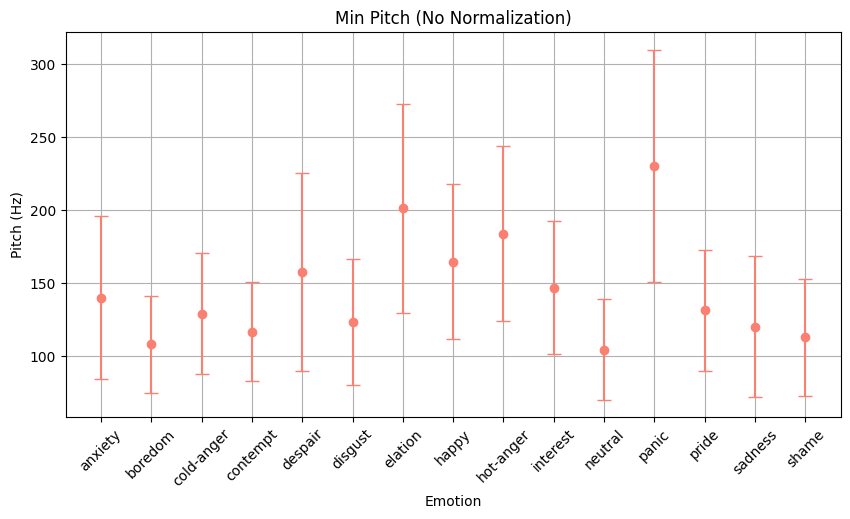

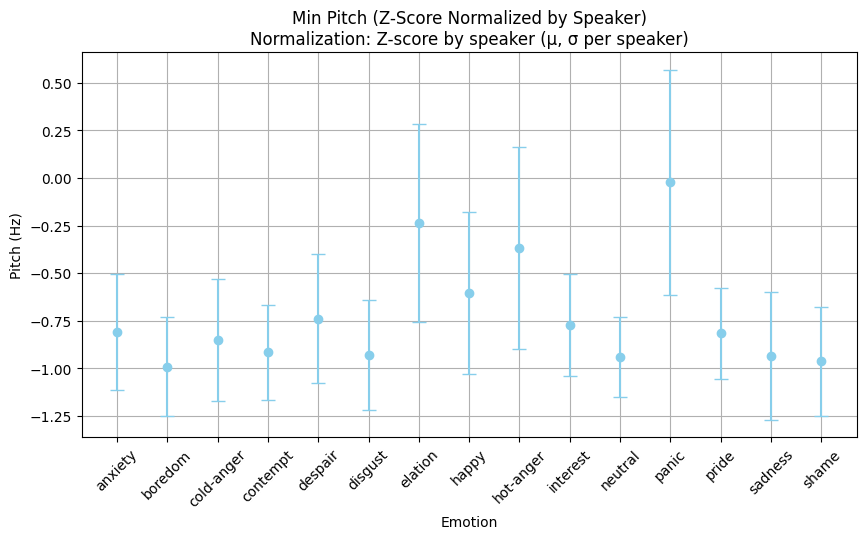

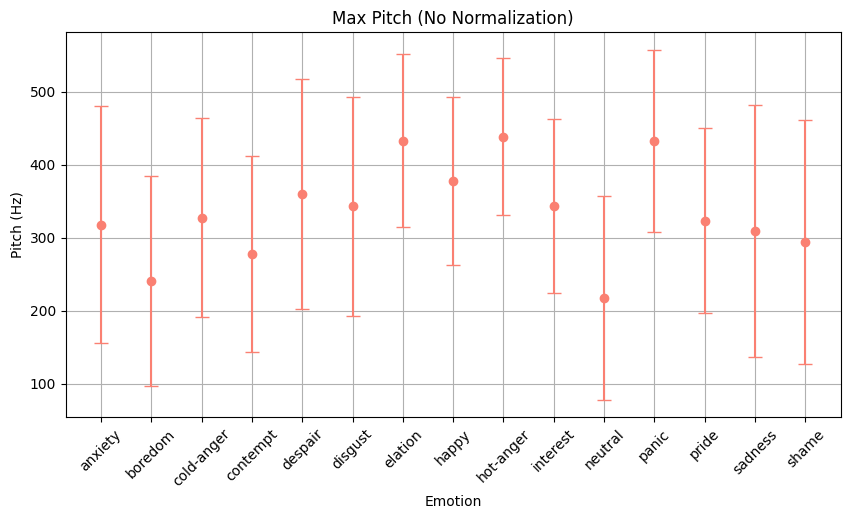

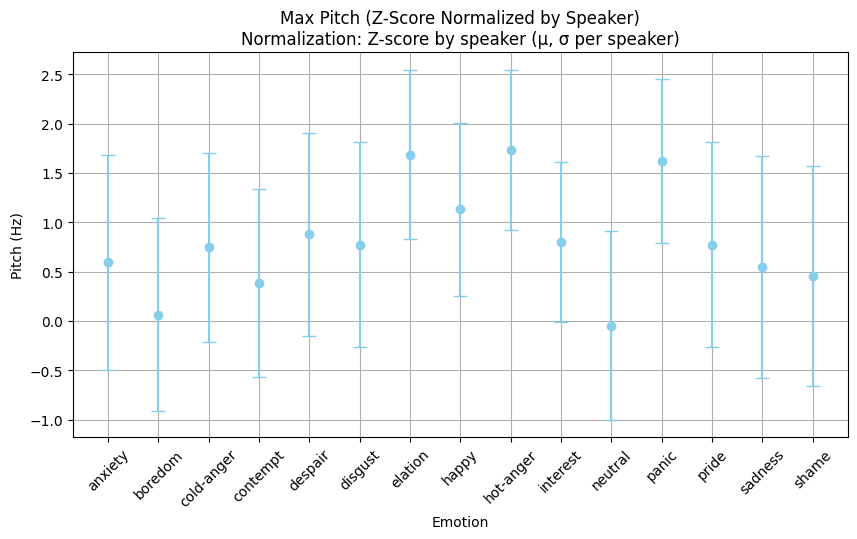

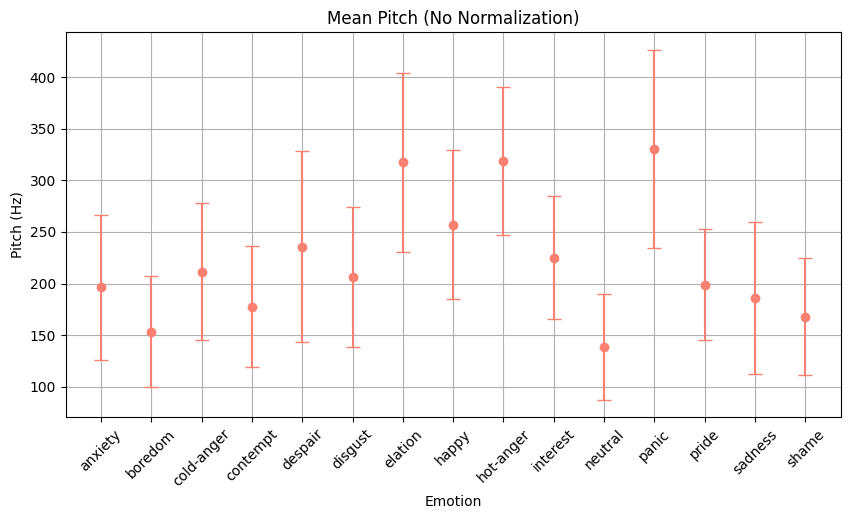

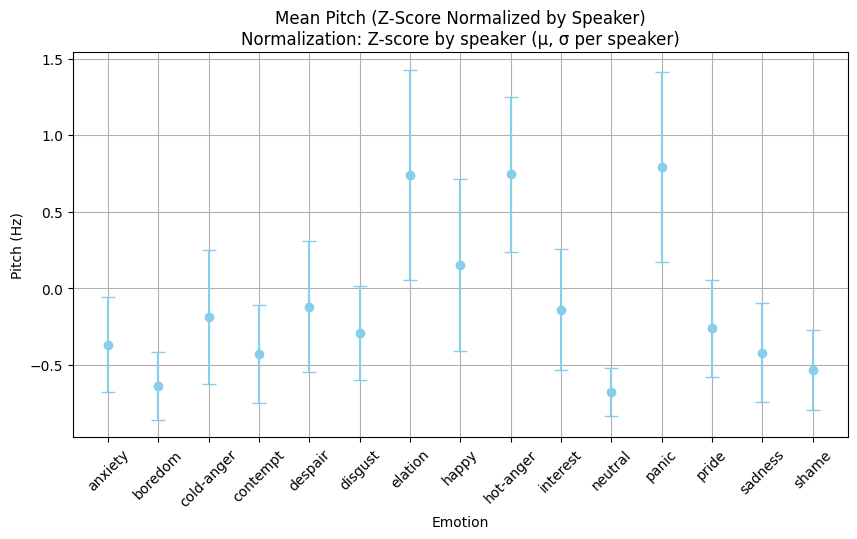

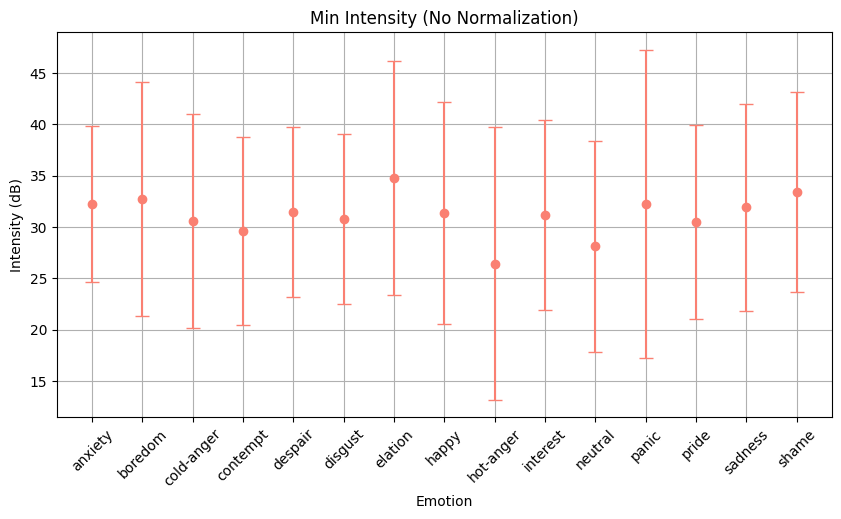

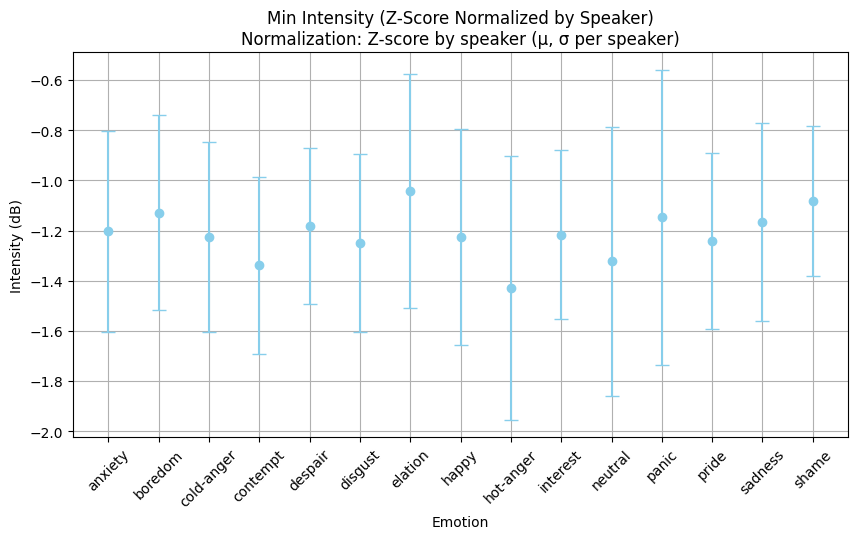

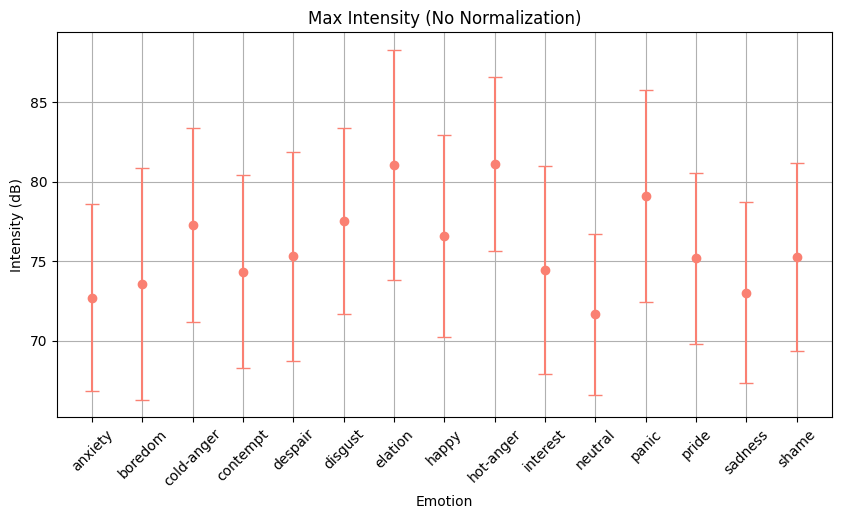

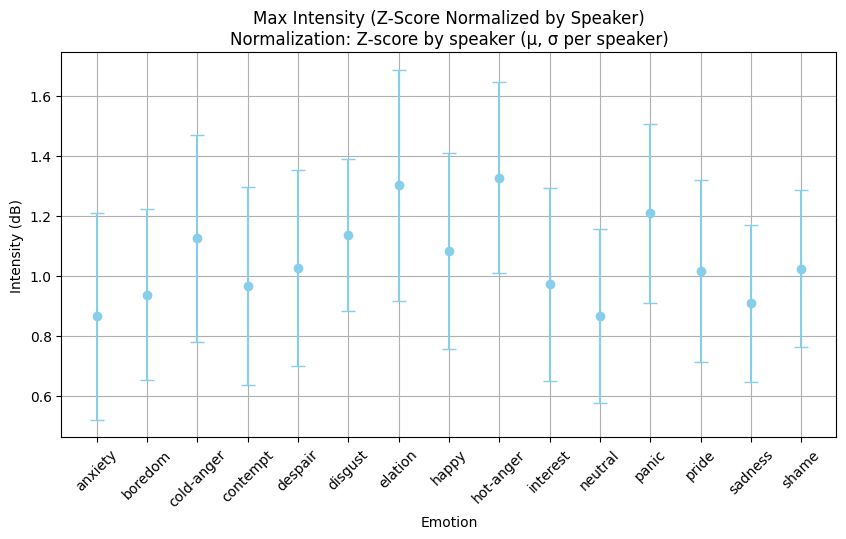

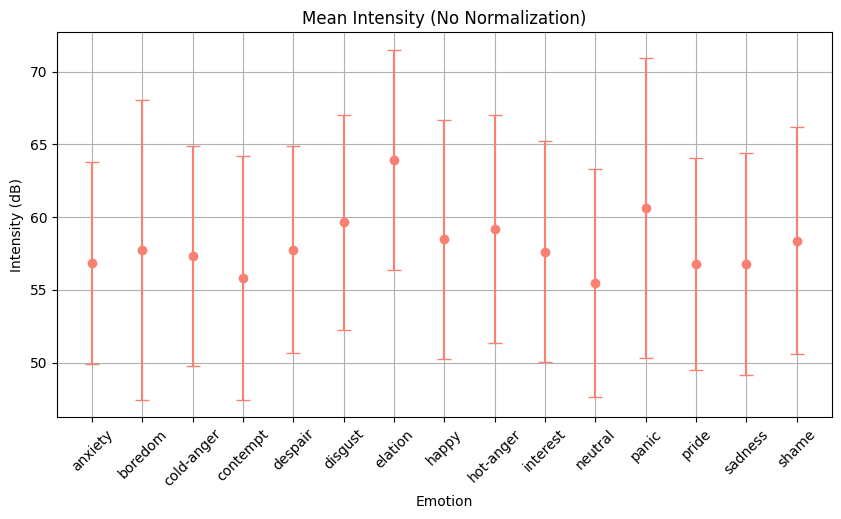

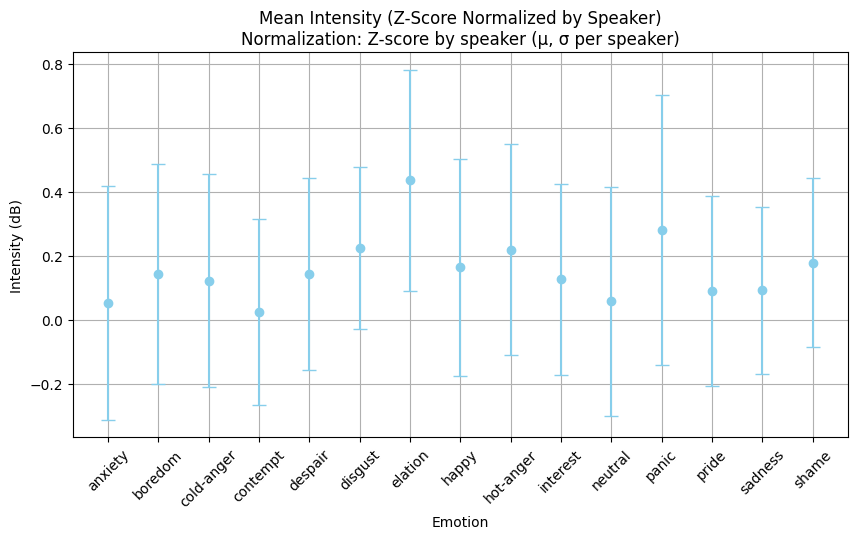

In [17]:
def plot_emotion_stats(df, feature, title, ylabel, normalize_method=None):
    emotion_stats = df.groupby('emotion')[feature].agg(['mean', 'std'])
    plt.figure(figsize=(10, 5))
    plt.errorbar(
        x=emotion_stats.index,
        y=emotion_stats['mean'],
        yerr=emotion_stats['std'],
        fmt='o',
        capsize=5,
        color='skyblue' if normalize_method else 'salmon'
    )
    plt.title(f"{title}\nNormalization: {normalize_method}" if normalize_method else title)
    plt.xlabel('Emotion')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# List of features and their labels
features = {
    'pitch_min': ('Min Pitch', 'Pitch (Hz)'),
    'pitch_max': ('Max Pitch', 'Pitch (Hz)'), 
    'pitch_mean': ('Mean Pitch', 'Pitch (Hz)'),
    'intensity_min': ('Min Intensity', 'Intensity (dB)'),
    'intensity_max': ('Max Intensity', 'Intensity (dB)'),
    'intensity_mean': ('Mean Intensity', 'Intensity (dB)')
}

# Generate all 12 plots
for feature, (title, ylabel) in features.items():
    # Plot WITHOUT normalization
    plot_emotion_stats(df, feature, f"{title} (No Normalization)", ylabel)
    
    # Plot WITH normalization (Z-score by speaker)
    plot_emotion_stats(
        df_normalized, 
        feature, 
        f"{title} (Z-Score Normalized by Speaker)", 
        ylabel,
        normalize_method="Z-score by speaker (μ, σ per speaker)"
    )